In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [4]:
!git pull https://github.com/rohit-khoiwal-30/msgmt.git

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/rohit-khoiwal-30/msgmt
 * branch            HEAD       -> FETCH_HEAD
Updating 2b5677b..d7f9235
Fast-forward
 useCONCT.ipynb | 306 ++++++++++++++++++++++++++++++---------------------------
 1 file changed, 163 insertions(+), 143 deletions(-)


In [5]:
df = pd.read_csv("augment_train.csv")
df_test = pd.read_csv("evaluation.csv")

In [6]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from keras.regularizers import l2

try:
    import tensorflow_hub as hub
except ModuleNotFoundError:
    %pip install -q tensorflow_hub
    import tensorflow_hub as hub
    
try:
    from keras_self_attention import SeqSelfAttention
except ModuleNotFoundError:
    %pip install -q keras-self-attention
    from keras_self_attention import SeqSelfAttention

import numpy as np

import math as m

In [7]:
huburl = "https://tfhub.dev/google/universal-sentence-encoder/4" 
fine_tuned_module_object = hub.load(huburl)

In [8]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    text_batch, reason_batch, y_hat = [], [], []
    all_groups = list(range(in_groups[0].shape[0]))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        text_batch += [in_groups[0][c_idx] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            y_hat += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            y_hat += [0]*batch_halfsize
            
        reason_batch += [in_groups[1][c_idx] for c_idx in b_group_idx]
            
    return np.stack(text_batch, 0), np.stack(reason_batch, 0), np.stack(y_hat, 0)

def siam_gen(in_groups, batch_size = 32):
    while True:
        text_stack, reason_stack, y_hatstack = gen_random_batch(in_groups, batch_size//2)
        yield [text_stack, reason_stack], y_hatstack

def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [9]:
def accuracy(y_true, y_pred):
    results = (y_pred >= 0.5).astype(int).squeeze()
    return np.mean([y_true == results])

In [10]:
def get_model():
    shared_embedding_layer1 = hub.KerasLayer(fine_tuned_module_object, trainable=True, name="first")
    shared_embedding_layer2 = hub.KerasLayer(fine_tuned_module_object, trainable=True, name="second")

    left_input = tf.keras.Input(shape=(), dtype=tf.string)
    right_input = tf.keras.Input(shape=(), dtype=tf.string)

    embedding_left_output= shared_embedding_layer1(left_input)
    a = tfl.Dropout(0.3)(embedding_left_output)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dropout(rate=0.2)(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.Lambda(lambda x: K.l2_normalize(x,axis=-1))(a)

    embedding_right_output= shared_embedding_layer2(right_input)
    b = tfl.Dropout(0.3)(embedding_right_output)
    b = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(b)
    b = tfl.Lambda(lambda x: K.l2_normalize(x,axis=-1))(b)

    distance = tfl.Lambda(euclidean_distance)([a, b])
    model = Model([left_input, right_input], distance)
    return model

In [11]:
model = get_model()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 first (KerasLayer)             (None, 512)          256797824   ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['first[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 64)           32832       ['dropout[0][0]']                
                                                                                              

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss = contrastive_loss, metrics = [tf.metrics.BinaryAccuracy()])

In [15]:
eval_df = df_test[df_test['label'] == 1]

In [30]:
loss_history = model.fit(siam_gen([df["clean_text"], df["reason"]], 64), 
                         validation_data = siam_gen([eval_df["clean_text"].values, eval_df["reason"].values], 64),
                         steps_per_epoch=50, validation_steps=10, epochs = 30, 
                         verbose = True, use_multiprocessing=True)

Epoch 1/30
50/50 [==============================] - 15s 303ms/step - loss: 0.3292 - binary_accuracy: 0.3156 - val_loss: 0.3080 - val_binary_accuracy: 0.2969
Epoch 2/30
50/50 [==============================] - 9s 187ms/step - loss: 0.3251 - binary_accuracy: 0.3097 - val_loss: 0.3086 - val_binary_accuracy: 0.3016
Epoch 3/30
50/50 [==============================] - 10s 193ms/step - loss: 0.3244 - binary_accuracy: 0.3225 - val_loss: 0.3032 - val_binary_accuracy: 0.2875
Epoch 4/30
50/50 [==============================] - 10s 190ms/step - loss: 0.3207 - binary_accuracy: 0.3119 - val_loss: 0.3014 - val_binary_accuracy: 0.2937
Epoch 5/30
50/50 [==============================] - 10s 191ms/step - loss: 0.3206 - binary_accuracy: 0.3184 - val_loss: 0.2996 - val_binary_accuracy: 0.3016
Epoch 6/30
50/50 [==============================] - 9s 189ms/step - loss: 0.3138 - binary_accuracy: 0.3066 - val_loss: 0.2968 - val_binary_accuracy: 0.2922
Epoch 7/30
50/50 [==============================] - 10s 196m

In [42]:
y_preds = model.predict([df["clean_text"], df["reason"]])
y_preds = y_preds/max(y_preds)
y_preds = 1 - y_preds

In [43]:
max(y_preds), min(y_preds)

(array([0.9169201], dtype=float32), array([0.], dtype=float32))

In [44]:
accuracy(df['label'], y_preds)

0.898158311989267

In [45]:
from sklearn.metrics import brier_score_loss as brier_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [46]:
y_hat = (y_preds >= 0.5).astype(int)

In [47]:
print("Brier Loss                       : ", brier_loss(df['label'], 1 - y_preds))
print("Precision Score                  : ", precision_score(df['label'], y_hat))
print("Recall Score                     : ", recall_score(df['label'], y_hat))
print("F1 Score                         : ", f1_score(df['label'], y_hat))
# print("Roc AUC Score                    : ", roc_auc_score(df['label'], y_preds))
# print("BCE Loss                         : ", log_loss(df['label'], y_preds))

Brier Loss                       :  0.4872207287488869
Precision Score                  :  1.0
Recall Score                     :  0.898158311989267
F1 Score                         :  0.9463471053138856


In [48]:
y_preds = model.predict([df_test["clean_text"], df_test["reason"]])
y_preds = y_preds/max(y_preds)
y_preds = 1 - y_preds

In [49]:
max(y_preds), min(y_preds)

(array([0.9352132], dtype=float32), array([0.], dtype=float32))

In [52]:
accuracy(df_test['label'], y_preds)

0.37855555555555553

In [53]:
y_hat = (y_preds >= 0.5).astype(int)

In [54]:
print("Brier Loss                       : ", brier_loss(df_test['label'], y_preds))
print("Precision Score                  : ", precision_score(df_test['label'], y_hat))
print("Recall Score                     : ", recall_score(df_test['label'], y_hat))
print("F1 Score                         : ", f1_score(df_test['label'], y_hat))
print("Roc AUC Score                    : ", roc_auc_score(df_test['label'], y_preds))
print("BCE Loss                         : ", log_loss(df_test['label'], y_preds))

Brier Loss                       :  0.36695016568645494
Precision Score                  :  0.3454567135702361
Recall Score                     :  0.9653448850383206
F1 Score                         :  0.5088258540440854
Roc AUC Score                    :  0.6184023284120607
BCE Loss                         :  0.9764636291782889


In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(df_test['label'], y_preds)
roc_auc = auc(fpr, tpr)

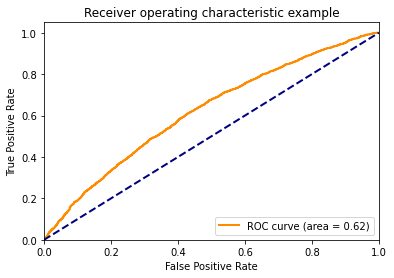

In [56]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from numpy import asarray
from numpy import savetxt
# define data
data1 = asarray([fpr])
data2 = asarray([tpr])

# save to csv file
savetxt('roc/useCONCT/fprdata.csv', data1, delimiter=',')
savetxt('roc/useCONCT/tprdata.csv', data2, delimiter=',')



In [ ]:
model.save("models/useEUCL/")

In [ ]:
Brier Loss                       :  0.31402411891819043
Precision Score                  :  0.3515442352651655
Recall Score                     :  0.9520159946684439
F1 Score                         :  0.5134795111430626
Roc AUC Score                    :  0.6291315685792128
BCE Loss                         :  0.8344145754683866